In [1]:
import copy
import gzip
import os
import random
import shutil
import zipfile
from datetime import timedelta
from pathlib import Path

import community as community_louvain
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from networkx.drawing.layout import forceatlas2_layout as _forceatlas2_layout
from pyvis.network import Network
from tqdm import auto as tqdm


def forceatlas2_layout(*args, **kwargs) -> dict:
    return _forceatlas2_layout(*args, **kwargs)

# Download the Files

- The files are available at https://snap.stanford.edu/data/higgs-twitter.html

- Base URL: https://snap.stanford.edu/data/higgs-*

| File Name                   | Description                                                                                    |
| --------------------------- | ---------------------------------------------------------------------------------------------- |
| social_network.edgelist.gz  | Friends/follower graph (directed)                                                              |
| retweet_network.edgelist.gz | Graph of who retweets whom (directed and weighted)                                             |
| reply_network.edgelist.gz   | Graph of who replies to who (directed and weighted)                                            |
| mention_network.edgelist.gz | Graph of who mentions whom (directed and weighted)                                             |
| higgs-activity_time.txt.gz  | The dataset provides information about activity on Twitter during the discovery of Higgs boson |


In [2]:
def download_file(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    local_filename = os.path.join(dest_folder, url.split("/")[-1])
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get("content-length", 0))
        with (
            open(local_filename, "wb") as f,
            tqdm(
                desc=local_filename,
                total=total_size,
                unit="iB",
                unit_scale=True,
                unit_divisor=1024,
            ) as bar,
        ):
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                bar.update(len(chunk))
    return local_filename


def unzip_file(zip_path, extract_to):
    if zipfile.is_zipfile(zip_path):
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_to)
    elif zip_path.endswith(".gz"):
        with gzip.open(zip_path, "rb") as f_in:
            with open(os.path.splitext(zip_path)[0], "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)


def main():
    base_url = "https://snap.stanford.edu/data/higgs-"
    files = [
        "social_network.edgelist.gz",
        "retweet_network.edgelist.gz",
        "reply_network.edgelist.gz",
        "mention_network.edgelist.gz",
        "activity_time.txt.gz",
    ]
    dest_folder = "higgs_twitter_data"

    for file_name in files:
        url = base_url + file_name
        output_path = Path(dest_folder) / ("higgs-" + file_name.replace(".gz", ""))
        if output_path.exists():
            print(f"{file_name} already exists. Skipping download.")
            continue
        print(f"Downloading {url}...")
        downloaded_file = download_file(url, dest_folder)
        print(f"Unzipping {downloaded_file}...")
        unzip_file(downloaded_file, dest_folder)
        os.remove(downloaded_file)  # Remove the compressed file after extraction
        print(f"Finished processing {file_name}.\n")


main()

social_network.edgelist.gz already exists. Skipping download.
retweet_network.edgelist.gz already exists. Skipping download.
reply_network.edgelist.gz already exists. Skipping download.
mention_network.edgelist.gz already exists. Skipping download.
activity_time.txt.gz already exists. Skipping download.


# Understanding Edge List File Format

- For this exercise, we will only explore the social network (followers/friends) edge list file: `social_network.edgelist.gz` and the activity time file: `higgs-activity_time.txt.gz`
- First we extract the largest connected component from the social network and use this subgraph for our analysis.
- This file contains four columns: userA userB timestamp interaction type
- every edge is directed from userA to userB
- First let's try to load this file using pandas and explore its contents.


In [3]:
main_event_date = pd.to_datetime("2012-07-04")

In [4]:
# Let's create a network graph using NetworkX
follower_df = pd.read_csv(
    os.path.join("higgs_twitter_data", "higgs-social_network.edgelist"),
    sep=" ",
    header=None,
    names=["source", "target"],
).reset_index(drop=True)

# Create a directed graph from the follower data
F: nx.DiGraph = nx.from_pandas_edgelist(
    follower_df,
    source="source",
    target="target",
    create_using=nx.DiGraph,
)

# Let's identify the largest weakly connected component (LCC) for the follower graph
largest_wcc = max(nx.weakly_connected_components(F), key=len)

F_wcc = F.subgraph(largest_wcc)

print(
    f"Follower graph LCC has {F_wcc.number_of_nodes()} nodes and {F_wcc.number_of_edges()} edges."
)

Follower graph LCC has 456290 nodes and 14855466 edges.


In [5]:
# Display the first 5 nodes in the LCC
[n for i, n in enumerate(F_wcc.nodes()) if i < 5]

[1, 2, 3, 4, 5]

In [6]:
df = pd.read_csv(
    os.path.join("higgs_twitter_data", "higgs-activity_time.txt"),
    sep=" ",
    header=None,
    names=["source", "target", "timestamp", "type"],
)
print(f"Total interactions in dataset: {len(df)}")

# filter interactions where both source and target are in the follower LCC
df = df[
    (df["source"].isin(largest_wcc)) & (df["target"].isin(largest_wcc))
].reset_index(drop=True)

print(f"Total interactions after filtering to follower LCC: {len(df)}")

# Convert timestamp to datetime
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")

# let's look at the distribution of interaction types
interaction_counts = df["type"].value_counts()
print("Interaction type distribution:")
print(interaction_counts)

# Get {DT} days before and after the main event date
# DT = 1
# start_date = main_event_date - pd.Timedelta(days=DT)
# end_date = main_event_date + pd.Timedelta(days=DT)
# df = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)]
df = df[df["type"] == "RE"]
start_date = df["datetime"].min()

# If one is interested in building a network of how information flows, then the direction of RT should be reversed when used in the analysis.
#   ref. https://snap.stanford.edu/data/higgs-twitter.html
df = df.rename(columns={"source": "target", "target": "source"})

total_number_of_nodes = df[["source", "target"]].stack().nunique()
total_number_of_edges = len(df)

print(f"Total number of unique nodes: {total_number_of_nodes}")
print(f"Total number of edges: {total_number_of_edges}")

df.head(5)

Total interactions in dataset: 563069
Total interactions after filtering to follower LCC: 562809
Interaction type distribution:
type
RT    354841
MT    171112
RE     36856
Name: count, dtype: int64
Total number of unique nodes: 38845
Total number of edges: 36856


,target,source,timestamp,type,datetime
1,223789,213163,1341100972,RE,2012-07-01 00:02:52
9,184615,364376,1341101523,RE,2012-07-01 00:12:03
15,364376,184615,1341101750,RE,2012-07-01 00:15:50
31,325916,325915,1341103100,RE,2012-07-01 00:38:20
36,325916,325915,1341103328,RE,2012-07-01 00:42:08


In [7]:
# let's look at the time range of the interactions
min_time = df["datetime"].min()
max_time = df["datetime"].max()
print(f"Time range of interactions: {min_time} to {max_time}")

Time range of interactions: 2012-07-01 00:02:52 to 2012-07-07 23:58:50


In [8]:
G: nx.DiGraph = nx.from_pandas_edgelist(
    df,
    source="source",
    target="target",
    edge_attr=["datetime", "type"],
    create_using=nx.DiGraph,
)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 38845 nodes and 32479 edges.


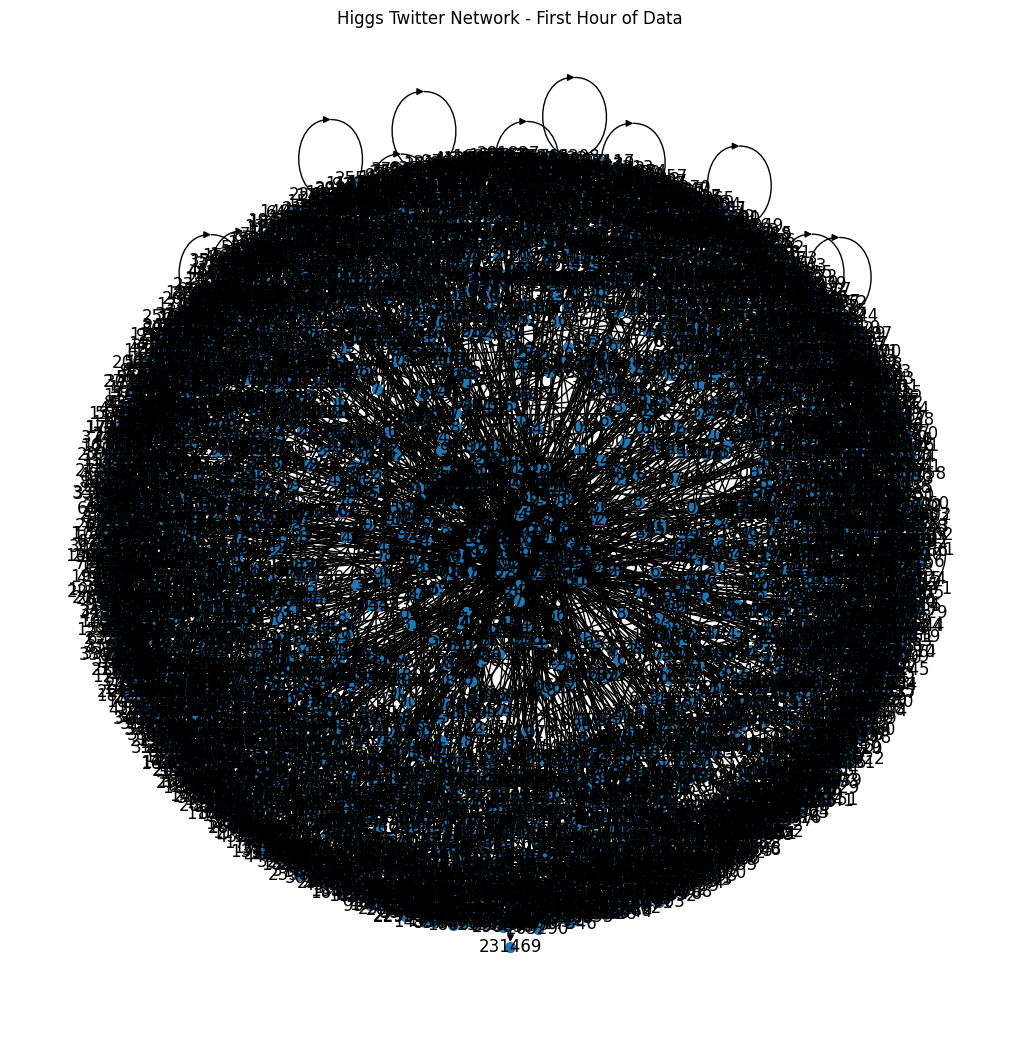

In [9]:
# Let's show the graph with matplotlib for the first hour of data

sampled_df = df[(start_date <= df["datetime"]) & (df["datetime"] < main_event_date)]

H: nx.DiGraph = nx.from_pandas_edgelist(
    sampled_df,
    source="source",
    target="target",
    edge_attr=["datetime", "type"],
    create_using=nx.DiGraph,
)

plt.figure(figsize=(10, 10))

pos = forceatlas2_layout(
    H,
    max_iter=20,  # default is 100, higher values give more precise layout
    jitter_tolerance=0.5,  # default is 1.0, lower is more precise
    scaling_ratio=3.0,  # default is 2.0, higher values spread out the layout
    gravity=0.5,  # default is 1.0, higher values pull nodes towards the center
)

nx.draw(H, pos, with_labels=True, node_size=50, font_size=12)

plt.title("Higgs Twitter Network - First Hour of Data")

plt.show()

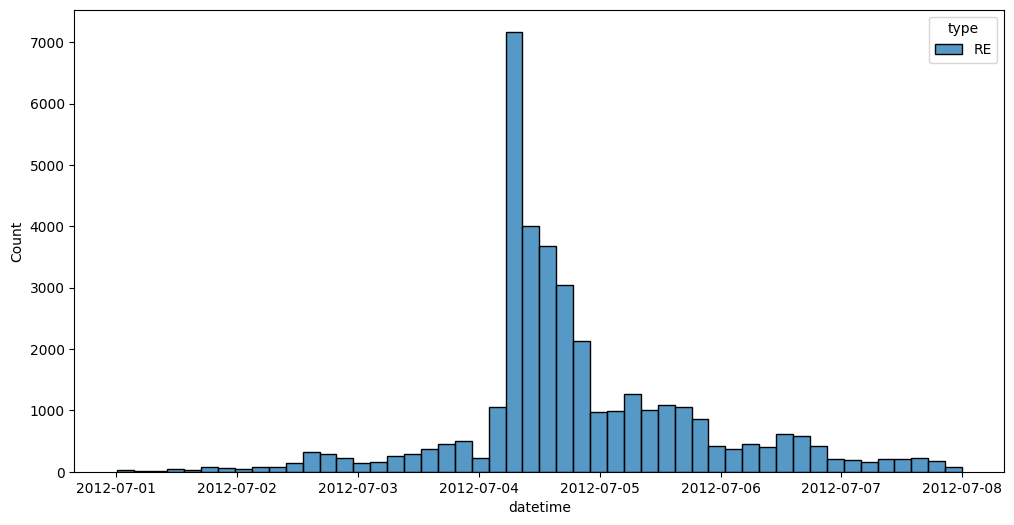

In [10]:
# Visualise early diffusion: e.g., plot number of new retweeters over time.
plt.figure(figsize=(12, 6))

sns.histplot(
    df,
    x="datetime",
    bins=50,
    kde=False,
    hue="type",
    multiple="stack",
)

plt.show()


In [11]:
# Compute degree
print("Computing node degrees...")
degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, "degree")

# in degree
in_degree_dict = dict(G.in_degree())
nx.set_node_attributes(G, in_degree_dict, "in_degree")

Computing node degrees...


In [12]:
# Compute betweenness centrality

# # print("Computing betweenness centrality...")
# # takes around 15 mins-45mins
# centrality_dict = nx.betweenness_centrality(G)
# nx.set_node_attributes(G, centrality_dict, "betweenness_centrality")

# follwing is a more efficient way using igraph, commented out for now

# compute betweenness centrality for all vertices using igraph
print("Computing betweenness centrality using igraph...")
G_ig = ig.Graph.from_networkx(G)
vertex_betweenness = G_ig.betweenness()

# put it back to networkx graph
# betweenness_dict = {v.index: float(vertex_betweenness[v.index]) for v in G_ig.vs}
names = [v["_nx_name"] for v in G_ig.vs]
betweenness_dict = dict(zip(names, vertex_betweenness))
nx.set_node_attributes(G, betweenness_dict, "betweenness_centrality")

Computing betweenness centrality using igraph...


In [13]:
# closeness centrality
print("Computing closeness centrality...")

closeness_dict = nx.closeness_centrality(G)

nx.set_node_attributes(G, closeness_dict, "closeness_centrality")

Computing closeness centrality...


In [14]:
# Run PageRank algorithm
print("Computing PageRank...")

pagerank_dict = nx.pagerank(G, alpha=0.85)

nx.set_node_attributes(G, pagerank_dict, "pagerank")

Computing PageRank...


In [15]:
# Compute clustering coefficient
print("Computing clustering coefficient...")

clustering_dict = nx.clustering(G.to_undirected())

nx.set_node_attributes(G, clustering_dict, "clustering_coefficient")

Computing clustering coefficient...


In [16]:
# Add modularity class using the Louvain method
partition = community_louvain.best_partition(G.to_undirected())

nx.set_node_attributes(G, partition, "modularity_class")

In [17]:
# Common measure for quantifying influence of bloggers is to use in-degree centrality
# - This is the number of users who follow a person on Twitter.
# In-links are sparse
# - More detailed analysis is required to measure influence

in_degrees: dict[str, float] = nx.get_node_attributes(G, "in_degree")
threshold = np.percentile(list(in_degrees.values()), 99)  # top 1%

influencers = [n for n, deg in in_degrees.items() if deg >= threshold]
regulars = [n for n in G.nodes if n not in influencers]

print(f"Influencers: {len(influencers)} | Regulars: {len(regulars)}")

# add this back to the network G
influencer_dict = {n: n in influencers for n in G.nodes}
nx.set_node_attributes(G, influencer_dict, "is_influencer")

Influencers: 418 | Regulars: 38427


In [18]:
# show node & edge attributes
print("Node attribute names for first node:")
first_node = list(G.nodes)[0]
print(G.nodes[first_node].keys())
print("Edges attribute names for first node:")
first_edge = list(G.edges)[0]
print(G.edges[first_edge].keys())

Node attribute names for first node:
dict_keys(['degree', 'in_degree', 'betweenness_centrality', 'closeness_centrality', 'pagerank', 'clustering_coefficient', 'modularity_class', 'is_influencer'])
Edges attribute names for first node:
dict_keys(['datetime', 'type'])


In [19]:
def build_cascades(G: nx.DiGraph, time_window: timedelta | int | None) -> list[set]:
    if isinstance(time_window, timedelta):
        time_window = time_window.total_seconds()
    cascades = []
    visited = set()
    for node in G.nodes():
        if node in visited:
            continue
        # Start a cascade
        cascade = set([node])
        queue = [(node, 0)]  # (node, timestamp)
        visited.add(node)
        while queue:
            current, t_curr = queue.pop(0)
            for nbr in G.successors(current):
                edge = G.get_edge_data(current, nbr, default={})
                # typeof datetime is pandas.Timestamp
                t_edge = edge["datetime"].timestamp()
                # convert to real time and print
                print(
                    f"Current: {current} at {pd.to_datetime(t_curr, unit='s')}, Neighbor: {nbr} at {pd.to_datetime(t_edge, unit='s')}"
                )
                # if time_window is not None and (t_edge - t_curr > time_window):
                #     continue
                if nbr not in visited:
                    cascade.add(nbr)
                    queue.append((nbr, t_edge))
                    visited.add(nbr)
        cascades.append(cascade)
    # filter cascades with size > 1
    cascades = [c for c in cascades if len(c) > 1]
    return cascades


cascades = build_cascades(G, time_window=timedelta(minutes=1))
print(f"Total cascades found: {len(cascades)}")

Current: 213163 at 1970-01-01 00:00:00, Neighbor: 223789 at 2012-07-01 00:02:52
Current: 213163 at 1970-01-01 00:00:00, Neighbor: 246023 at 2012-07-04 02:58:08
Current: 246023 at 2012-07-04 02:58:08, Neighbor: 213163 at 2012-07-04 03:00:49
Current: 364376 at 1970-01-01 00:00:00, Neighbor: 184615 at 2012-07-01 00:12:03
Current: 184615 at 2012-07-01 00:12:03, Neighbor: 364376 at 2012-07-03 00:36:14
Current: 325915 at 1970-01-01 00:00:00, Neighbor: 325916 at 2012-07-01 00:42:08
Current: 244881 at 1970-01-01 00:00:00, Neighbor: 205864 at 2012-07-01 00:44:02
Current: 244881 at 1970-01-01 00:00:00, Neighbor: 244882 at 2012-07-04 12:23:51
Current: 244882 at 2012-07-04 12:23:51, Neighbor: 244881 at 2012-07-04 12:26:39
Current: 18038 at 1970-01-01 00:00:00, Neighbor: 300856 at 2012-07-01 00:53:28
Current: 42514 at 1970-01-01 00:00:00, Neighbor: 203358 at 2012-07-01 01:01:55
Current: 235556 at 1970-01-01 00:00:00, Neighbor: 149403 at 2012-07-01 01:10:16
Current: 6695 at 1970-01-01 00:00:00, Neig

In [20]:
largest_cascade = max(cascades, key=len)
print(f"Largest cascade size: {len(largest_cascade)}")

Largest cascade size: 3107


In [21]:
import hvplot.networkx as hvnx
import holoviews as hv

hv.extension("bokeh")  # enables interactive plots in notebooks

In [22]:
def show_network_hvplot(
    G: nx.Graph, sample_size: int | None = None, date_format: str = "%Y-%m-%d"
):
    # Sample graph to manageable size
    if sample_size is not None and len(G.nodes) > sample_size:
        nodes_sample = random.sample(list(G.nodes()), sample_size)
        G_copy = copy.deepcopy(G.subgraph(nodes_sample))
    else:
        G_copy = copy.deepcopy(G)

    # Convert Timestamp attributes to strings
    for n, data in G_copy.nodes(data=True):
        for k, v in list(data.items()):
            if isinstance(v, pd.Timestamp):
                data[k] = v.strftime(date_format)

    for u, v, data in G_copy.edges(data=True):
        for k, val in list(data.items()):
            if isinstance(val, pd.Timestamp):
                data[k] = val.strftime(date_format)

    # Compute layout (spring layout works well for most graphs)
    pos = nx.spring_layout(G_copy, seed=42, k=0.1)

    # Create hvplot
    plot = hvnx.draw(
        G_copy,
        pos,
        node_size=10,
        node_color="lightblue",
        edge_color="gray",
        with_labels=False,
    ).opts(
        width=900,
        height=700,
        tools=["hover", "box_zoom", "wheel_zoom", "save", "reset"],
        title=f"Interactive Graph (|N|={len(G_copy)}, |E|={len(G_copy.edges)})",
    )

    # Add hover info dynamically
    hover_data = []
    for n, d in G_copy.nodes(data=True):
        hover_data.append({"id": n, **d})
        # You can attach hover info via node attributes if needed

    return plot

In [23]:
# show_network_hvplot(G)